In [85]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import edhec_risk_kit as erk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
ind = erk.get_ind_returns()
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


```python
def plot_ef2(n_points, er, cov, style = '.-'):
    if er.shape[0] !=2 or er.shape[0] !=2:
        raise ValueError('plot_ef2 can only plot 2 asset frontiers')
    weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
    #weights = minimize_vol(target_return)??????????
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({'Returns': rets, 'Volatility': vols})
    return ef.plot.line('Volatility', 'Returns', style = style)
```

In [97]:
er = erk.annualize_rets(ind['1996':'2000'], 12)
cov = ind['1996':'2000'].cov()

l = ['Games', 'Fin']

In [98]:
from scipy.optimize import minimize


def minimize_vol(target_return, er, cov):
    """
    target_ret -> W
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n) #equal weighting
    
    #Define Constraints
    bounds = ((0.0, 1.0), ) * n #makes n copies of the tuple
    return_is_target = { 
        'type': 'eq', #it's an equality constraint, should be 0 when succeeds
        'args': (er,), 
        'fun': lambda w, er: target_return - erk.portfolio_return(w, er)
    }
    weights_sum_to_1= {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    results = minimize(erk.portfolio_vol, init_guess,
                      args = (cov,), method = 'SLSQP',
                      options = {'disp': False},
                      constraints = (return_is_target, weights_sum_to_1),
                      bounds = bounds
                      )
    return results.x

In [102]:
w15 = erk.minimize_vol(.15, er[l], cov.loc[l,l])
vol15 = erk.portfolio_vol(w15, cov.loc[l,l])

In [100]:
vol15

0.056163669406706564

In [101]:
w15

array([0.47287631, 0.52712369])

In [108]:
def optimal_weights(n_points, er, cov):
    """
    _> list of weights to run the optimizer on to minimize the vol
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [erk.minimize_vol(target_return, er, cov) for target_return in target_rs]
    
    return weights

def plot_ef(n_points, er, cov, style = '.-'):
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({'Returns': rets, 'Volatility': vols})
    return ef.plot.line('Volatility', 'Returns', style = style)

<AxesSubplot:xlabel='Volatility'>

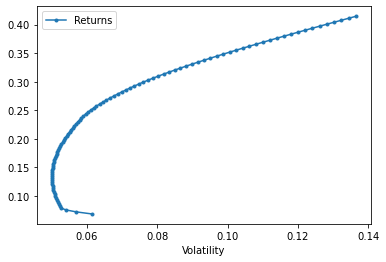

In [111]:
l = ['Smoke', 'Fin', 'Games', 'Coal']

erk.plot_ef(100, er[l], cov.loc[l,l])

<AxesSubplot:xlabel='Volatility'>

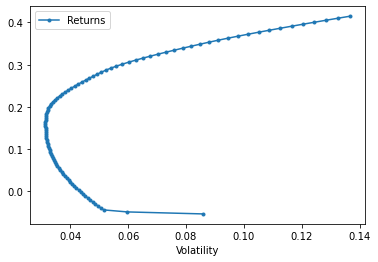

In [112]:
erk.plot_ef(100, er, cov)